In [144]:
import glob
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdatesx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from typing import List

In [145]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# COVID-19 Daily Observation Data

Data from [2019 Novel Coronavirus COVID-19 (2019-nCoV) Data repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE.

## Load data
We're going to read in all of the data in the [csse_covid_19_daily_reports](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports) directory, and aggregate it into a single `DataFrame`.

First, the dates across the files aren't in a consistent format, so we need a utility to normalize our dates:

In [85]:
def normalize_date(date: str) -> pd.Timestamp:
    """Converts various timestamps into consistent format."""
    return pd.Timestamp(date)

assert extract_month_day("1/22/2020 17:00") == pd.Timestamp("2020-01-22 17:00:00")
assert extract_month_day("01/22/2020 02:00") == pd.Timestamp("2020-01-22 02:00:00")
assert extract_month_day("2020-02-02T23:43:02") == pd.Timestamp("2020-02-02 23:43:02")
assert extract_month_day("2020-03-23 23:19:34") == pd.Timestamp("2020-03-23 23:19:34")

There are a couple more utilities we need to read in the data:

In [108]:
def list_source_files(dir_name: str) -> List[str]: 
    """Returns a list of all the source files."""
    pattern = r"(\d{2}-\d{2}-\d{4}).csv"
    src = "{}/*.csv".format(dir_name)
    return [f for f in glob.glob(src) if re.search(pattern, f)]

def read_combined_daily_data(file_names: List[str], rename_cols_map):
    """Reads in all the data, combines it in single DataFrame."""
    # Note handling inconsistent column names
    dfs = [pd.read_csv(f).rename(columns=rename_cols_map) for f in files] 
    data = pd.concat(dfs)
    return data

Now we can read in the data, aggregate it, and clean it up:

In [124]:
DIR = "csse_covid_19_daily_reports"

RENAME_COLS = { 'Country_Region': 'Country/Region', 'Province_State': 'Province/State', 
          'Last_Update': 'Last Update'}

# Read in data as single DataFrame
files = list_source_files(DIR)
data = read_combined_daily_data(files, RENAME_COLS)

# Cleanup: select columns NaN -> 0
NUMERIC_COLS = ['Confirmed', 'Deaths', 'Recovered']
data[NUMERIC_COLS] = data[NUMERIC_COLS].fillna(0)
    
# Cleanup: drop anything without cases (removes an error for DC data)
data = data[data['Confirmed'] > 0]

# Cleanup: Augment data with normalized "Date" field
data['Last Update'] = data['Last Update'].apply(normalize_date)

COLUMNS_TO_KEEP = ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']

# Cleanup: remove unused columns
data = data[COLUMNS_TO_KEEP]

# This is time series data, so update index and sort
data = data.set_index('Last Update')
data = data.sort_values(by=['Last Update'])

data

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Last Update,,,,,
2020-01-22 17:00:00,Henan,Mainland China,5.0,0.0,0.0
2020-01-22 17:00:00,Zhejiang,Mainland China,10.0,0.0,0.0
2020-01-22 17:00:00,NaN,Japan,2.0,0.0,0.0
2020-01-22 17:00:00,Hebei,Mainland China,1.0,0.0,0.0
2020-01-22 17:00:00,NaN,Thailand,2.0,0.0,0.0
...,...,...,...,...,...
2020-03-26 23:53:24,South Australia,Australia,235.0,0.0,6.0
2020-03-26 23:53:24,Tasmania,Australia,47.0,0.0,3.0
2020-03-26 23:53:24,Victoria,Australia,520.0,3.0,149.0


We should be able to access data using date ranges:

In [125]:
data.loc['2020-03-19':'2020-03-21']

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Last Update,,,,,
2020-03-19 00:16:00,Inner Mongolia,China,75.0,1.0,74.0
2020-03-19 00:16:31,Inner Mongolia,China,75.0,1.0,74.0
2020-03-19 00:16:31,Inner Mongolia,China,75.0,1.0,74.0
2020-03-19 01:02:56,Shandong,China,761.0,7.0,747.0
2020-03-19 01:02:56,Macau,China,17.0,0.0,10.0
...,...,...,...,...,...
2020-03-21 23:13:18,Delaware,US,45.0,0.0,0.0
2020-03-21 23:13:18,Maryland,US,193.0,2.0,0.0
2020-03-21 23:43:02,NaN,Cape Verde,1.0,0.0,0.0


## Region-specific cumulative data

In [150]:
# source: https://stackoverflow.com/a/43631028
def plot_time_series_data(x_col, y_col):
    """Renders a line graph for time series data, making graph more legible"""
    fig, ax = plt.subplots()
    ax.plot(x_col, y_col)
    
    # make dates legible
    myFmt = DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(myFmt)
    
    # rotate dates to improve legibility
    fig.autofmt_xdate()
    plt.show()

Hubei cumulative confirmed cases:

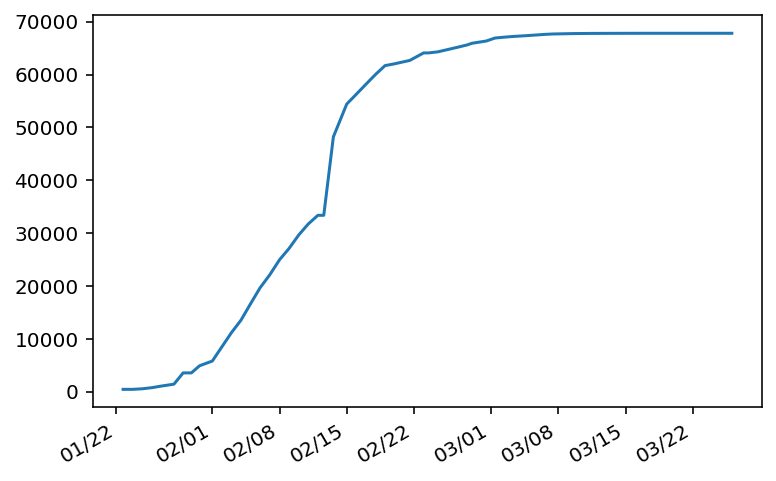

In [154]:
hubei = data.loc[data['Province/State'] == 'Hubei']
plot_time_series_data(hubei.index, hubei["Confirmed"])

DC cumulative confirmed cases:

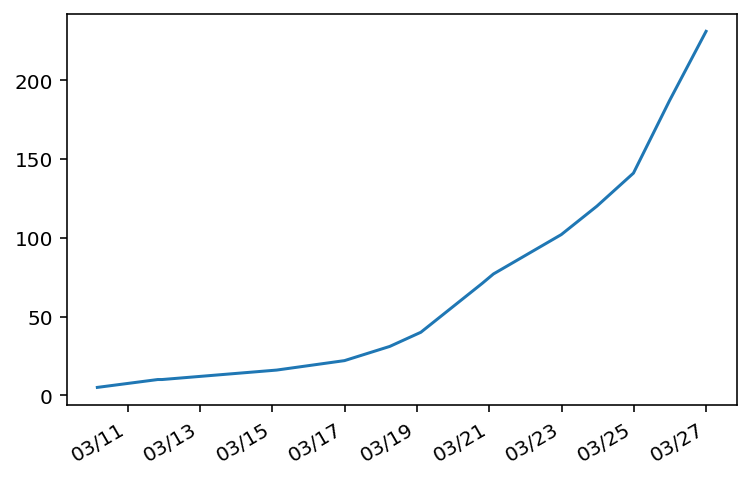

In [155]:
dc = data.loc[data['Province/State'] == 'District of Columbia']
plot_time_series_data(dc.index, dc["Confirmed"])